In [1]:
# 참고 사이트 : https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
#  https://mac-user-guide.tistory.com/79

In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [3]:
# conda install -c conda-forge lightgbm
import lightgbm
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [4]:
# gpu 사용
# os.environ["CUDA_VISIBLE_DEVICE"]=''

In [5]:
src_null = pd.read_csv('./null.csv')
src_p0171 = pd.read_csv('./p0171.csv')
print(src_null.shape)
print(src_p0171.shape)

# null , p0171 concat
src = pd.concat([src_null , src_p0171])
src= src.sort_values(by=['srcEngineLoad'], axis=0,ascending=True)

src.shape
src.head(5)

(463, 9)
(459, 9)


,Unnamed: 0,srcSpeed,srcAPS,srcGyroValue,srcRPM,srcTPS,srcMAF,srcEngineLoad,Diagnose
458,462,0.0,0.0,-1.340918,0.0,13.594771,0.0,0.0,P0171
202,204,0.0,0.0,0.476363,0.0,11.428571,0.0,0.0,P0171
204,206,0.0,0.0,-0.145657,0.0,0.000000,0.0,0.0,P0171
205,207,0.0,0.0,-0.272466,0.0,0.000000,0.0,0.0,P0171
206,208,0.0,0.0,-0.343108,0.0,10.370370,0.0,0.0,P0171


In [6]:
y_data = src.iloc[:,8]
y_data = y_data.replace(np.NaN , 'NULL')
y_data



458    P0171
202    P0171
204    P0171
205    P0171
206    P0171
       ...  
205     NULL
219     NULL
222     NULL
396     NULL
126     NULL
Name: Diagnose, Length: 922, dtype: object

In [7]:
# NULL : 0 , P0171 : 1로 라벨링
y_data = pd.get_dummies(y_data).values
y_data = y_data[:,0] 

where_0 = np.where(y_data ==1)
where_1 = np.where(y_data ==0)

y_data[where_0] = 1
y_data[where_1] = 0
y_data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:

x_data = src.iloc[:,1:8] # srcSpeed ~ srcEngineLoad
x_data = x_data.apply(pd.to_numeric, errors='coerce')

#x_data = x_data.values
x_data
x_data.shape


(922, 7)

In [9]:
from sklearn.model_selection import train_test_split
trnx, tstx, trny, tsty = train_test_split(x_data, y_data, test_size=0.3, random_state=88)
trnx, valx, trny, valy = train_test_split(trnx, trny, test_size=0.2, random_state=111)

# 데이터 정규화

In [10]:
# 학습 데이터에서만 fit_transform
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trnx = scaler.fit_transform(trnx)
tstx = scaler.transform(tstx)

# 모델 (LGBM)

In [11]:
'''
categorical_features = [c for c, col in enumerate(src.columns) if 'P0171' in col]
train_data = lightgbm.Dataset(trnx, label=trny, categorical_feature=categorical_features)
val_data = lightgbm.Dataset(valx, label=valy)
'''

"\ncategorical_features = [c for c, col in enumerate(src.columns) if 'P0171' in col]\ntrain_data = lightgbm.Dataset(trnx, label=trny, categorical_feature=categorical_features)\nval_data = lightgbm.Dataset(valx, label=valy)\n"

In [12]:
'''모델 '''
# 객체 생성
model = lightgbm.LGBMClassifier(boosting_type='gbdt' 
                               ,num_leaves = 7
                               ,max_depth= 3
                                
                               ,learning_rate=0.028
                                
                               ,n_estimators=100
                               ,objective = None    
                               )
# , eval_metric='logloss'
lgb_model = model.fit(trnx, trny, early_stopping_rounds=100 ,eval_set=[(valx, valy)])

# 예측하기
y_pred = lgb_model.predict(tstx)
y_pred_probs = lgb_model.predict_proba(tstx)[:,1]



'''
 srcTPS , srcGyroValue ,  srcEngineLoad , srcAPS , srcRPM, srcMAF, srcSpeed 
 순으로 importance를 보입니다.
'''


[1]	valid_0's binary_logloss: 0.694895
[2]	valid_0's binary_logloss: 0.696813
[3]	valid_0's binary_logloss: 0.698886
[4]	valid_0's binary_logloss: 0.701102
[5]	valid_0's binary_logloss: 0.696639
[6]	valid_0's binary_logloss: 0.692425
[7]	valid_0's binary_logloss: 0.688445
[8]	valid_0's binary_logloss: 0.684687
[9]	valid_0's binary_logloss: 0.687094
[10]	valid_0's binary_logloss: 0.683585
[11]	valid_0's binary_logloss: 0.680266
[12]	valid_0's binary_logloss: 0.677129
[13]	valid_0's binary_logloss: 0.674161
[14]	valid_0's binary_logloss: 0.671744
[15]	valid_0's binary_logloss: 0.674354
[16]	valid_0's binary_logloss: 0.674805
[17]	valid_0's binary_logloss: 0.672712
[18]	valid_0's binary_logloss: 0.675541
[19]	valid_0's binary_logloss: 0.672926
[20]	valid_0's binary_logloss: 0.671062
[21]	valid_0's binary_logloss: 0.668585
[22]	valid_0's binary_logloss: 0.665586
[23]	valid_0's binary_logloss: 0.666454
[24]	valid_0's binary_logloss: 0.667372
[25]	valid_0's binary_logloss: 0.664726
[26]	vali

C:\Users\shsy1\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


'\n srcTPS , srcGyroValue ,  srcEngineLoad , srcAPS , srcRPM, srcMAF, srcSpeed \n 순으로 importance를 보입니다.\n'

In [13]:
trnx_pd = pd.DataFrame(x_data)
fi_df = pd.DataFrame(lgb_model.feature_importances_, index = trnx_pd.columns , columns = ['importance']).sort_values(by= 'importance' , ascending =False)
fi_df = fi_df[fi_df.importance >0]
fi_df = fi_df.reset_index()
fi_df

,index,importance
0,srcAPS,196
1,srcGyroValue,89
2,srcTPS,83
3,srcEngineLoad,53
4,srcMAF,37
5,srcRPM,32
6,srcSpeed,3


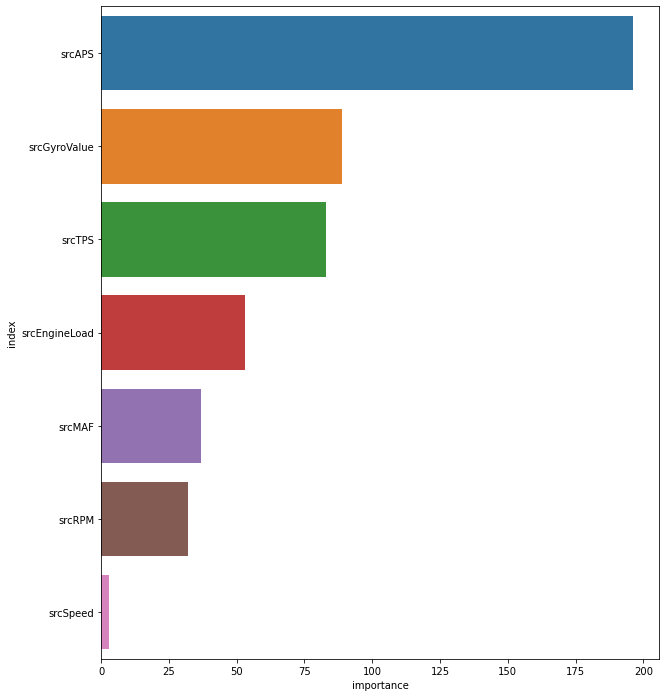

In [14]:
# 특성 중요도 시각화
fig , ax = plt.subplots()
ax = sns.barplot(y = fi_df['index'] , x = fi_df['importance'])
fig.set_size_inches(10,12)

In [15]:
src.head(2)

,Unnamed: 0,srcSpeed,srcAPS,srcGyroValue,srcRPM,srcTPS,srcMAF,srcEngineLoad,Diagnose
458,462,0.0,0.0,-1.340918,0.0,13.594771,0.0,0.0,P0171
202,204,0.0,0.0,0.476363,0.0,11.428571,0.0,0.0,P0171


# Evaluation

In [16]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:1]
    get_clf_eval(tgt_test, pred, pred_proba)



In [17]:
def get_clf_eval(y_test, y_pred=None, pred_proba=None):
    confusion = metrics.confusion_matrix(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    AUC = metrics.roc_auc_score(y_test, y_pred, pred_proba)

    print('confusion_matrix:\n', confusion)
    print('\nAccuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [18]:
get_clf_eval(tsty , y_pred)

confusion_matrix:
 [[115  21]
 [ 21 120]]

Accuracy: 0.8484
Precision: 0.8511
Recall: 0.8511
F1: 0.8511
AUC: 0.8483


C:\Users\shsy1\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass average=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [23]:
# AUC 면적 구하기
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

lr_model = lgb_model
lr_model.fit(trnx , trny)
prediction = lr_model.predict(tstx)

AUC value: 0.8446495619524406


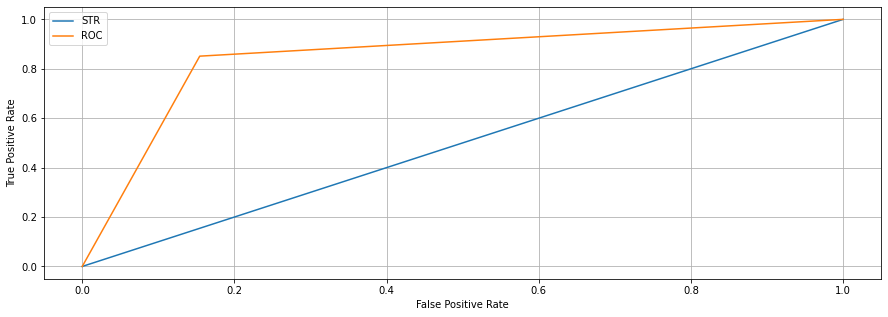

In [24]:
# ROC Curve
fprs , tprs , thresholds = roc_curve(tsty , y_pred)
plt.figure(figsize = (15,5))
plt.plot([0,1],[0,1] , label = 'STR')
plt.plot(fprs , tprs , label = 'ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show

print('AUC value: {}'.format(roc_auc_score(tsty, prediction)))

In [25]:

y_pre_df = pd.DataFrame(y_pred)
y_pre_df = y_pre_df.replace(0 , 'NULL')

y_pre_df = y_pre_df.replace(1 , ' P0171')
y_pre_df = y_pre_df.rename(columns={0:'predict' })
y_pre_df

,predict
0,NULL
1,P0171
2,NULL
3,NULL
4,NULL
...,...
272,NULL
273,P0171
274,NULL
275,NULL


In [26]:

y_df = pd.DataFrame(tsty)
y_df = y_df.replace(0 , 'NULL')

y_df = y_df.replace(1 , ' P0171')
y_df = y_df.rename(columns={0:'Target' })
y_df

,Target
0,NULL
1,NULL
2,NULL
3,P0171
4,P0171
...,...
272,NULL
273,P0171
274,NULL
275,NULL
